# HiddenLayer Graph Demo - TensorFlow

In [1]:
import os
from __future__ import absolute_import, division, print_function  # TODO: needed?
import tensorflow as tf
import tensorflow.contrib.slim.nets as nets
import hiddenlayer as hl
import hiddenlayer.transforms as ht

# Hide GPUs. Not needed for this demo.
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## VGG 16

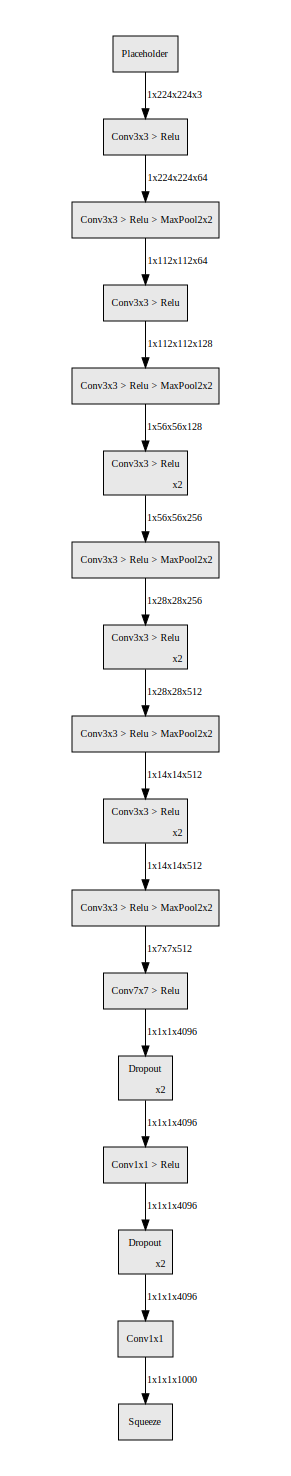

In [2]:
with tf.Session() as sess:
    with tf.Graph().as_default() as g:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.vgg.vgg_16(inputs)
        # Build HiddenLayer graph
        hidden_graph = hl.Graph(g)

# Display graph (or use IPython.display())
hidden_graph

## ResNet v1 50

Instructions for updating:
keep_dims is deprecated, use keepdims instead


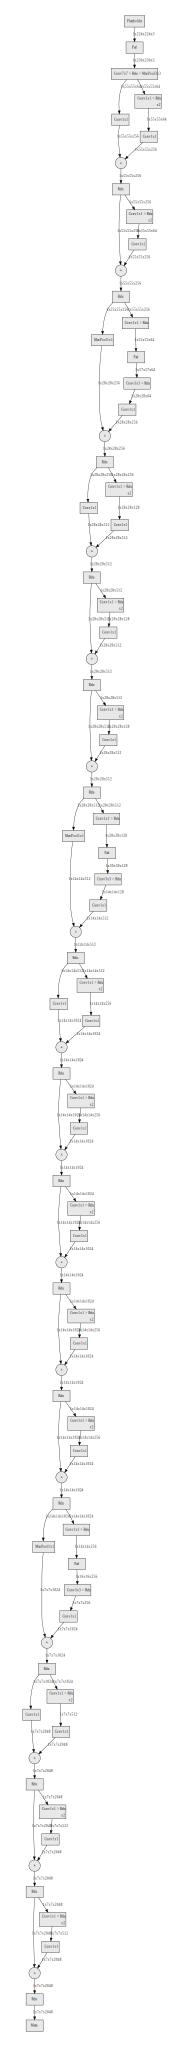

In [3]:
with tf.Session() as sess:
    with tf.Graph().as_default() as g:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.resnet_v1.resnet_v1_50(inputs)
        # Build HiddenLayer graph
        hg = hl.Graph(g)

# Display
hg

# Inception v1

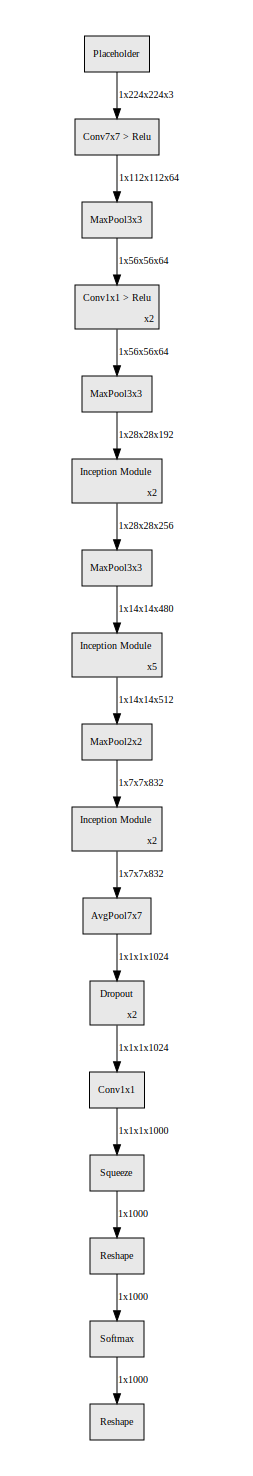

In [4]:
transforms = [
    ht.Fold("""
        ( (MaxPool > Conv > Relu) |
          (Conv > Relu > Conv > Relu) |
          (Conv > Relu > Conv > Relu) |
          (Conv > Relu)
        ) > Concat
    """, "Inception", "Inception Module"),
    ht.Fold("Conv > Relu", "ConvRelu"),
    ht.FoldDuplicates(),
]

with tf.Session() as sess:
    with tf.Graph().as_default() as g:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.inception.inception_v1(inputs)
        # Build layout
        hg = hl.Graph(g, transforms=transforms)


# Display graph
hg

# Alexnet v2

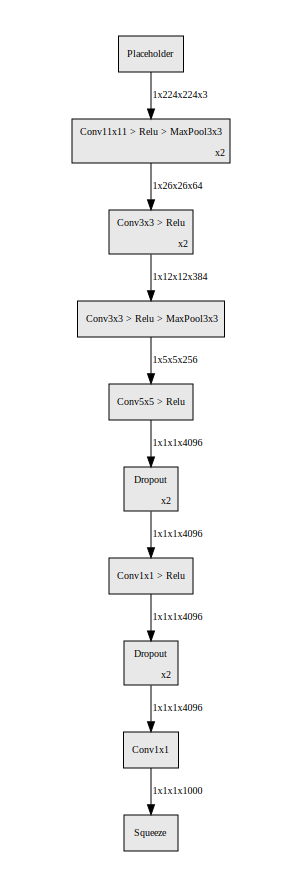

In [5]:
with tf.Session() as sess:
    with tf.Graph().as_default() as g:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
        # Build model
        predictions, _ = nets.alexnet.alexnet_v2(inputs)
        # Build layout
        hg = hl.Graph(g)

# Display graph
hg

# Overfeat

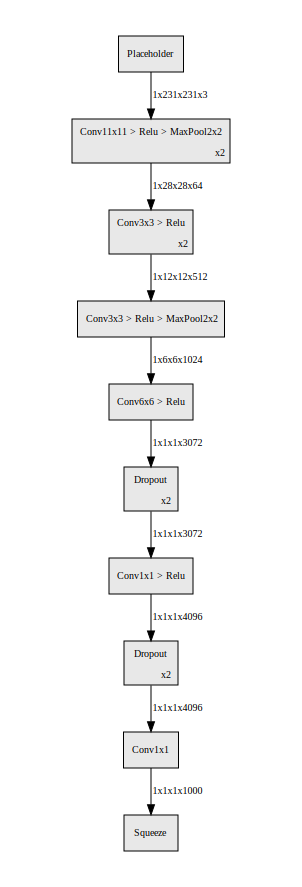

In [6]:
with tf.Session() as sess:
    with tf.Graph().as_default() as g:
        # Setup input placeholder
        inputs = tf.placeholder(tf.float32, shape=(1, 231, 231, 3))
        # Build model
        predictions, _ = nets.overfeat.overfeat(inputs)
        # Build layout
        hg = hl.Graph(g)

# Display
hg